In [1]:
import matplotlib.pyplot as plt
import numpy as np
import microtool as mt 

%matplotlib widget

# Inversion recovery

## 1. Create a tissue model specifying a T1 and T2

In [2]:
relaxation_model = mt.tissue_model.RelaxationTissueModel(t1=900, t2=90)
print(relaxation_model)

Tissue model with 3 scalar parameters:
    - T1: 900 (scale: 900, optimize: False)
    - T2: 90 (scale: 90, optimize: True)
    - S0: 1.0 (scale: 1.0, optimize: False)


## 2. Create an initial inversion-recovery acquisition scheme
Initial TR = 500 ms, initial TE = 10 ms, initial TI = {50, ..., 400} ms

In [3]:
tr = np.repeat(500,8)
te = np.array([10, 10, 10, 10, 20, 20, 20, 20])
ti = np.array([50, 100, 150, 200, 250, 300, 350, 400])
bounds = [(0,1000),(0,100),(0,1000)]

ir_scheme = mt.acquisition_scheme.InversionRecoveryAcquisitionScheme(tr, te, ti,bounds=bounds)
print(ir_scheme)

Acquisition scheme with 8 measurements and 3 scalar parameters:
    - RepetitionTimeExcitation: [500. 500. 500. 500. 500. 500. 500. 500.] ms in range 0 to 1000
    - EchoTime: [10. 10. 10. 10. 20. 20. 20. 20.] ms (fixed parameter) in range 0 to 100
    - InversionTime: [ 50. 100. 150. 200. 250. 300. 350. 400.] ms in range 0 to 1000


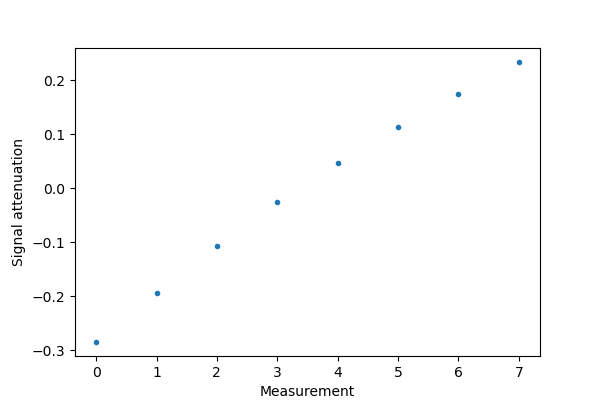

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(relaxation_model(ir_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');


## 3. Optimize the acquisition scheme

In [5]:
noise_variance = 0.1
relaxation_model.optimize(ir_scheme, noise_variance)

TypeError: object of type 'AcquisitionParameters' has no len()

In [ ]:
print(ir_scheme)
plt.figure()
plt.plot(relaxation_model(ir_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');


# Custom bruteforce optimizer

In [ ]:
# Minimal working example for use with brute_force method.
tr = np.repeat(500,2)
te = np.array([10,60])
ti = np.array([50,30])

# Setting boundaries on the acquisition parameters
tr_range = (0,1000)
te_range = (0,100)
ti_range = (0,50)
ir_scheme = mt.acquisition_scheme.InversionRecoveryAcquisitionScheme(tr, te, ti, bounds=[tr_range,te_range,ti_range])
print(ir_scheme)

# Copying ir_scheme to compare optimization methods
scheme_brute = ir_scheme
scheme_default = ir_scheme

In [ ]:
noise_variance = 0.1
relaxation_model.optimize(scheme_brute, noise_variance,method=mt.optimize.brute_force)
relaxation_model.optimize(scheme_default,noise_variance)

In [ ]:
print("Brute Force scheme:\n",scheme_brute)
print("Default optimizer:\n", scheme_default)
plt.figure()
plt.plot(relaxation_model(scheme_brute), '.',label = 'Brute Force')
plt.plot(relaxation_model(scheme_default),'.',label = "Default optimizer")
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation')
plt.legend()

# Testing constraints with fixed parameter

## preliminaries

In [ ]:
# Minimal working example for use with brute_force method.
tr = np.repeat(500,2)
te = np.array([10,60])
ti = np.array([50,30])

# Setting boundaries on the acquisition parameters
tr_range = (0,1000)
te_range = (0,100)
ti_range = (0,50)
ir_scheme = mt.acquisition_scheme.InversionRecoveryAcquisitionScheme(tr, te, ti, bounds=[tr_range,te_range,ti_range])
print(ir_scheme)

# dmpyi diffusion model

In [ ]:
from dmipy.signal_models.cylinder_models import C1Stick
from dmipy.signal_models.gaussian_models import G1Ball
from dmipy.core.modeling_framework import MultiCompartmentModel

import microtool.dmipy

## 1. Create a 'stick' diffusion model

In [ ]:
dmipy_model = MultiCompartmentModel(models=[
    C1Stick(
        mu=[1, 1],  # Orientation in angles.
        lambda_par=0.001 * 1e-6  # Parallel diffusivity in m²/s.
    )
])

## 2. Add a diffusion model to the tissue

In [ ]:
diffusion_model = mt.dmipy.DmipyTissueModel(dmipy_model)
diffusion_model

## 3. Create an initial diffusion acquisition scheme

In [ ]:
b_values = np.array([0, 1000, 2000, 3000])  # s/mm²
b_vectors = np.array([[0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])
pulse_widths = np.full(b_values.shape, 10)  # ms
pulse_intervals = np.full(b_values.shape, 30)  # ms

diffusion_scheme = mt.acquisition_scheme.DiffusionAcquisitionScheme(b_values, b_vectors, pulse_widths, pulse_intervals)
print(diffusion_scheme)

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(diffusion_model(diffusion_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');
print(diffusion_scheme.get_free_parameters())

## 5. Calculate the Cramer-Rao lower bound loss

In [ ]:
jacobian = diffusion_model.jacobian(diffusion_scheme)  # Jacobian of the signal with respect to the relevant tissue parameters.
scales = [p.scale for p in diffusion_model.values()]  # Tissue parameter scales.
include = [p.optimize for p in diffusion_model.values()]  # Include tissue parameter in optimization?
noise_variance = 0.1
mt.optimize.crlb_loss(jacobian, scales, include, noise_variance)

## 6. Optimize the acquisition scheme

In [ ]:
diffusion_model.optimize(diffusion_scheme, noise_variance)

In [ ]:
print(diffusion_scheme)
plt.figure(figsize=(6, 4))
plt.plot(diffusion_model(diffusion_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation')

## 7. Calculate the Cramer-Rao lower bound loss again
It should be lower after optimizing the acquisition.

In [ ]:
jacobian = diffusion_model.jacobian(diffusion_scheme)  # Jacobian of the signal with respect to the relevant tissue parameters.
scales = [p.scale for p in diffusion_model.values()]  # Tissue parameter scales.
include = [p.optimize for p in diffusion_model.values()]  # Include tissue parameter in optimization?
noise_variance = 0.1
mt.optimize.crlb_loss(jacobian, scales, include, noise_variance)